In [1]:
import numpy as np 
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
import cmasher as cmr
from matplotlib import cm
from matplotlib.colors import Normalize

from matplotlib import rc
fontsize = 8
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import magnetics
import cloud
from importlib import reload
reload(magnetics)
from magnetics import Domain
import cloud
reload(cloud)
from cloud import Cloud
from time import time
from joblib import Parallel, delayed
from units import kB
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


# https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
def rgb_white2alpha(rgb, ensure_increasing=False):
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1) / alpha
    # Concatenate our alpha channel
    return np.concatenate((rgb, alpha), axis=1)

def cmap_white2alpha(cmap, ensure_increasing=True, 
                     register=False):
    # Fetch the cmap callable
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    # Get the colors out from the colormap LUT
    name=""
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(rgb, ensure_increasing=ensure_increasing)
    # Create a new Colormap object
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=name + "_alpha")
    if register:
        matplotlib.cm.register_cmap(name=name + "_alpha", cmap=cmap_alpha)
    return cmap_alpha

def plot_phasespace_color_mJ(C, ax, ti=None, coordx="z", coordy="vz", cmap="viridis", s=3, scale_velocity=False,
                             Nsample=None, scatter=True,imshow=False):
    base_colors = plt.get_cmap(cmap, int(2*C.J+1))
    colors = np.array([list(base_colors(mJi))[:3]
              for mJi in range(int(2*C.J +1))])
    for mJi, mJ in enumerate(C.mJ_states):
        color_list = [[0.9999, 0.9999, 0.9999], colors[mJi]]
        cmap = LinearSegmentedColormap.from_list("", color_list)
        cmap = cmap_white2alpha(cmap)
        obj = C.plot_phasespace_slice(coordx, coordy, ti=ti, ax=ax,
                            scale_velocity=scale_velocity,
                            scatter_kwargs={
                                "cmap":cmap, "s":s,
                            },
                            Nsample=Nsample,
                            mJ_mask=mJ, 
                            scatter=scatter,
                            imshow=imshow,
                            contour=False);
    return obj


def calc_gJ(S, L, J):
    gs = 2.0023
    factor = (J*(J+1) - L*(L+1) + S*(S+1)) 
    factor /= (2*J*(J+1))
    return 1 + (gs - 1)*factor

In [3]:
RHH = 3.5
RAH = RHH/np.sqrt(3)
MHH = 7
MAH = 5
NHH = 2
NAH = 2
d=0.086
r0 = np.array([0,0,0.2])
IHH = 1000
IAHtoHH = 0.5
g = None #turn off gravity?
S = [0.25, 0.25, 0.25]
N = 1e4
recoil_factor = 25

In [4]:
#https://tel.archives-ouvertes.fr/tel-01571420v2/document
# Appendix A
atoms = ["Li", "Cr", "Er", "Dy"]
# ground state (S, L, J)
terms = [(1/2, 0, 1/2), 
         (3, 0, 3),
         (1, 5, 6),
         (2, 6, 8)]
MOT_wavelengths = np.array([671e-9, 425e-9, 583e-9, 626e-9])
masses = np.array([1.15e-26, 8.63e-26, 2.78e-25, 2.70e-25])
Trecoils = (6.6e-34/MOT_wavelengths)**2/(masses*1.38e-23) # (h/lmbda)^2 / (m kB)
vths = np.array([np.sqrt(kB*T/m) for T, m in zip(Trecoils*recoil_factor, masses)])
Js = np.array([term[2] for term in terms])
#gJs = [calc_gJ(*term) for term in terms]
gJs = [2.00232, 2.00183, 1.16381, 1.24159]  # NIST ASD values
Atoms = {}
keys = ["mass", "Trecoil", "vth", "J", "gJ"]
for atom, *vals in zip(atoms, masses, Trecoils, vths, Js, gJs):
    Atoms[atom] = {k:v for k, v in zip(keys, vals)}

In [5]:
import magnetics
reload(magnetics)
from magnetics import Field

mop = Field()
mop.add_HH(r0=r0,
           n=np.array([0,0,1]),
           ang=0,
           d=d,
           M=MHH,
           N=NHH,
           I=1,
           R=RHH,
           A=1/2*RHH - MHH/2*d
          )


mop.add_AH(r0=r0,
          n=np.array([0,0,1]),
           ang=0,
           d=d,
           M=MAH,
           N=NAH,
           I=IAHtoHH,
           R=RAH,
           A=np.sqrt(3)/2*RAH - MAH/2*d
          )

mop.make_interpolation(meshspec=[[-2, 2,100]]*3)

[ 19.27784835  19.27784835 954.76830547]
[11.61449236 11.61449236  6.94451788]
[0.60247867 0.60247867 0.00727351]
Plotting 3D field vectors...
Plotting 2D contour slice of gradient...


/home/lhillber/documents/research/mop_high_spin/tmps/magnetics.py:601: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Plotting 1D line cut of gradient...


<Figure size 432x288 with 0 Axes>

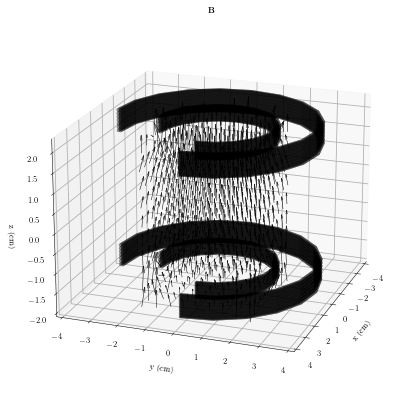

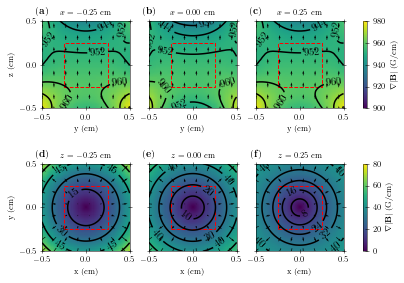

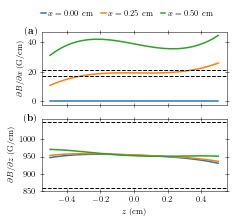

In [6]:
import magnetics
reload(magnetics)
from magnetics import Field
from matplotlib.patches import Rectangle

mop_plot = Field()


mop_plot.add_HH(r0=r0,
           n=np.array([0,0,1]),
           ang=0,
           d=d,
           M=MHH,
           N=NHH,
           I=IHH,
           R=RHH,
           A=1/2*RHH - MHH/2*d
          )


mop_plot.add_AH(r0=r0,
          n=np.array([0,0,1]),
           ang=0,
           d=d,
           M=MAH,
           N=NAH,
           I=IHH*IAHtoHH,
           R=RAH,
           A=np.sqrt(3)/2*RAH - MAH/2*d
          )


mop_plot.make_interpolation(meshspec=[[-2, 2,100]]*3)


#Statistics
plot_domain = Domain(meshspec=[[-0.5, 0.5, 75]]*3)
stats_domain = Domain(meshspec=[[0, 0.5, 75],[0, 0.5, 75],[-0.5, 0.5, 75]] )
#to Gauss
grad_data = 1e4*np.array([1e12*interp(stats_domain.points) for interp in mop_plot.gradnormB_interp])
mean = np.mean(grad_data, axis=1)
std = np.std(grad_data, axis=1)
print(mean)
print(std)
print(std/mean)

#3D plot
mop_plot.plot_3d(azim=20, elev=20, skip=12)
#plt.savefig("figures/mop_field_3D.pdf")
#plt.savefig("figures/mop_field_3D.png", dpi=600)

# 2D plots
fig2d, axs2d = mop_plot.plot_slices(planes={"x":[-0.25, 0.0, 0.25], "z":[-0.25, 0.0, 0.25]}, figsize=(2*3.375, 4),
                     grad_norm=True, domain=plot_domain, contours=5, gauss=True)
clims = [[900, 980], [0,80]]
for clim, axr in zip(clims, axs2d):
    for ax in axr:
        ax.add_patch(Rectangle((-0.25, -0.25), 0.5, 0.5, color="r", fill=None, alpha=1, ls="--"))
        for im in ax.get_images():
            im.set_clim(*clim)
axs2d[0,0].set_yticks([-0.5, 0, 0.5])
axs2d[1,0].set_yticks([-0.5, 0, 0.5])
plt.subplots_adjust(hspace=0.63, bottom=0.13)
fig2d.colorbar(cm.ScalarMappable(norm=Normalize(clims[0][0],clims[0][1]), cmap="viridis"), 
        ax=axs2d[0,:], location='right', ticks=[900, 920, 940, 960, 980], label=r"$\nabla |{\bf B}| ~{\rm (G/cm)}$")
fig2d.colorbar(cm.ScalarMappable(norm=Normalize(clims[1][0],clims[1][1]), cmap="viridis"), 
        ax=axs2d[1,:], location='right', ticks=[0, 20, 40, 60, 80], label=r"$\nabla |{\bf B}| ~{\rm (G/cm)}$")
fig2d.suptitle(None)
lettering(axs2d[0,0], -0.0, 1.1, 0)
lettering(axs2d[0,1], -0.0, 1.1, 1)
lettering(axs2d[0,2], -0.0, 1.1, 2)
lettering(axs2d[1,0], -0.0, 1.1, 3)
lettering(axs2d[1,1], -0.0, 1.1, 4)
lettering(axs2d[1,2], -0.0, 1.1, 5)

plt.savefig("figures/mop_gradnorm_slices.pdf")


#plt.savefig("figures/mop_gradnorm_slices.png", dpi=600)

# 1D plots
fig, axs = mop_plot.plot_linecuts(
        components="xz",
        lines=[[0.0, 0.0, "var"],[0.25, 0.0, "var"], [0.5, 0.0, "var"]],
        grad_norm=True,
        domain=plot_domain,
        gauss=True,
        figsize=(3.375, 3.), legend=False)

#axs[1].axhline(mean[2], c="k", zorder=1)
#axs[1].axhline(mean[2]+std[2], c="k", zorder=10)
#axs[1].axhline(mean[2]-std[2], c="k", zorder=10)
axs[1].axhline(mean[2]+mean[2]*0.1, ls="--", c="k", zorder=10, lw=1)
axs[1].axhline(mean[2]-mean[2]*0.1, ls="--", c="k", zorder=10, lw=1)

#axs[0].axhline(mean[1], c="k", zorder=10)
#axs[0].axhline(mean[1]+std[1], c="k", zorder=10)
#axs[0].axhline(mean[1]-std[1], c="k", zorder=10)
axs[0].axhline(mean[1]+mean[1]*0.1, ls="--", c="k", zorder=10, lw=1)
axs[0].axhline(mean[1]-mean[1]*0.1, ls="--", c="k", zorder=10, lw=1)
plt.tight_layout()
axs[0].legend([r"$x=0.00~{\rm cm}$", r"$x=0.25~{\rm cm}$", r"$x=0.50~{\rm cm}$"],
             frameon=False, handlelength=0.6, handletextpad=0.3, 
             labelspacing=0.2, loc="upper center", bbox_to_anchor=(0.46,1.4), ncol=3, columnspacing=1)
axs[1].set_yticks([850, 900, 950, 1000])
lettering(axs[0], -0.06, 1, 0)
lettering(axs[1], -0.06, 1, 1)
plt.subplots_adjust(top=0.9)

plt.savefig("figures/mop_gradnorm_lines.pdf")
#plt.savefig("figures/mop_gradnorm_lines.png", dpi=600)


In [7]:
def cycle_pulses(t0, tau, rule, ukick_factor):
    return [{"field": mop,
           "t0": 0,
           "tau": tau,
           "shape": "sin",
           "scale": 1000,
           "mJ_coord": "z",
           "mJ_rule": rule,
           "name": "kick"},
           
           {"field": None,
            "tau": 0,
           "t0": t0},
           
           {"field": mop,
           "t0": 0,
           "tau": tau,
           "shape": "sin",
           "scale": -1000*ukick_factor,
           "mJ_coord": None,
           "mJ_rule": rule,
           "name":"unkick" },
         ]


def get_sim(t0, tau, rule, J, gJ, mass, T, spatial_distribution, ukick_factor):
    tic = time()
    C = Cloud(
             g=g,
             S=S, 
             N=N,
             T=T,  
             J=J,
             gJ=gJ,
             mass=mass)
    C.initialize_state(spatial_distribution=spatial_distribution)
    C.initialize_run(cycle_pulses(t0, tau, rule, unkick_factor), dt=1.0)
    C.run()
    return C

In [8]:
n_jobs=-1
t0s = np.linspace(5e2, 4e4, 50)
taus = np.linspace(100, 1000, 1)
spatial_distributions = ["flat", "gauss"]
unkick_factor=1

args_list = []
for disti, dist in enumerate(spatial_distributions):
    if dist == "flat":
        rule = "equal_length"
    elif dist == "gauss":
        rule = "equal_number"
    for atomi, atom in enumerate(atoms):
        J = Atoms[atom]["J"]
        gJ = Atoms[atom]["gJ"]
        mass = Atoms[atom]["mass"]
        T = recoil_factor*Atoms[atom]["Trecoil"]
        for t0i, t0 in enumerate(t0s):
            for taui, tau in enumerate(taus):
                args = [t0, tau, rule, J, gJ, mass, T, dist, unkick_factor]
                args_list.append(args)
print(len(args_list))
sims = np.array(Parallel(n_jobs=n_jobs)(delayed(get_sim)(*args) for args in args_list)) 

400


figures/compression_factor_vs_unkick_delay_flat_equal_number_100us-pulse.pdf
figures/compression_factor_vs_unkick_delay_gauss_equal_number_100us-pulse.pdf


(-1.475, 40.0)

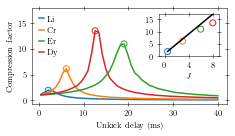

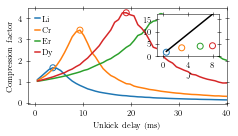

In [9]:
ratios = np.array([np.std(C.states[-1,:,:3]/np.std(C.states[0,:,:3], axis=0), axis=0) for C in sims])
ratios = ratios.reshape((len(spatial_distributions), len(Js), len(t0s), len(taus), 3));   
inds = np.argmax(1/ratios[:,:,:,:,2], axis=2)
t0_opts = np.zeros((len(spatial_distributions), len(Js), len(taus)))
ratio_opts = np.zeros((len(spatial_distributions), len(Js), len(taus)))


for taui, tau in enumerate(taus):
    for disti, dist in enumerate(spatial_distributions[:]):
        fig, ax = plt.subplots(1, 1, figsize=(3.375, 2))
        for atomi, name in enumerate(atoms):
            rs = ratios[disti, atomi,:, taui, :]
            color = f"C{atomi}"
            plt.plot(t0s/1e3, 1/rs[:, 2], c=color, ls="-", label=name, zorder=atomi)
            ind = inds[disti, atomi, taui]
            t0_opts[disti, atomi, taui] = t0s[ind]
            ratio_opts[disti, atomi, taui] = ratios[disti, atomi, ind, taui, 2]

            plt.scatter(t0s[ind]/1e3, 1/ratios[disti, atomi, ind, taui, 2], fc="none", ec=color)
        
        ax.legend(frameon=False, loc="upper left", handlelength=0.6, handletextpad=0.3,)
        ax.set_ylabel("Compression factor")
        ax.set_xlabel("Unkick delay (ms)")
        for atomi, name in enumerate(atoms):
            if disti == 0:
                plt.axhline(2*Atoms[name]["J"]+1, color=f"C{atomi}", lw=0)
            plt.tight_layout()
        inax = ax.inset_axes([0.65, 0.5, 0.31, 0.44])            
        inax.scatter(Js, 1/ratio_opts[disti].T[0], marker="o", fc="none", ec=["C0","C1","C2","C3"])
        inax.set_xticks([0,4,8])
        inax.set_yticks([0,5,10,15])
        inax.set_xlim(-1, 9)
        inax.set_ylim(0, 17)
        inax.plot(Js, 2*Js+1, c="k")
        inax.set_xlabel("$J$")
        fname = f"figures/compression_factor_vs_unkick_delay_{dist}_{rule}_{int(tau)}us-pulse.pdf"
        print(fname)
        plt.savefig(fname)
        #plt.savefig(f"figures/compression_factor_vs_unkick_delay_{spatial_distribution}_{rule}_{int(tau)}us-pulse.png", dpi=600)
    
ax.set_xlim(right=40)

In [50]:
19e-3*9.81 * 100

18.639

In [51]:
0.5*(19e-3)**2*9.81 * 100

0.1770705

In [13]:
1/ratio_opts

array([[[ 1.94072317],
        [ 6.13249984],
        [10.95032161],
        [13.49667534]],

       [[ 1.65790977],
        [ 3.43863226],
        [ 4.08831416],
        [ 4.26032593]]])

In [32]:
t0_opts

array([[[ 2112.24489796],
        [ 6142.85714286],
        [19040.81632653],
        [12591.83673469]],

       [[ 3724.48979592],
        [ 9367.34693878],
        [26295.91836735],
        [19040.81632653]]])

In [45]:
(1-np.sqrt(1 + (vths * t0_opts[0].T/S[2])**2))*1e2

array([[-0.0065323 , -0.0024455 , -0.0012033 , -0.00048388]])

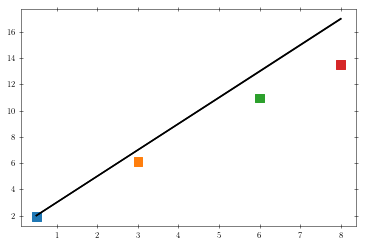

In [15]:
plt.scatter(Js, 1/ratio_opts[0].T[0], s=75, marker="s", c=["C0","C1","C2","C3"])
plt.plot(Js, 2*Js+1, c="k")
#plt.scatter(Js, 1/ratio_opts[1].T[0], s=75, c=["C0","C1","C2","C3"])

plt.plot(Js, S[2] / np.sqrt((S[2]/(2*Js+1))**2 + (vths * t0_opts[0].T[0])**2), c="k")

In [16]:

reload(cloud)

from cloud import Cloud
unkick_factor = 1.0

spatial_distribution = "flat"
atom = "Dy"
tau = 100
rule = "equal_length"

J = Atoms[atom]["J"]
gJ = Atoms[atom]["gJ"]
mass = Atoms[atom]["mass"]
T = 25*Atoms[atom]["Trecoil"]

Cs = []
for atomi, atom in enumerate(atoms):
    print(atom)
    J = Atoms[atom]["J"]
    gJ = Atoms[atom]["gJ"]
    mass = Atoms[atom]["mass"]
    T = recoil_factor*Atoms[atom]["Trecoil"]
    t0 = t0_opts[spatial_distributions.index(spatial_distribution), atoms.index(atom), list(taus).index(tau)]
    C = Cloud(g=g, S=S, N=N, T=T, J=J, gJ=gJ, mass=mass)
    C.initialize_state(spatial_distribution=spatial_distribution)
    pulses = cycle_pulses(t0, tau, rule, unkick_factor)
    C.initialize_run(pulses, dt=1.0)
    C.run()
    Cs.append(C)

Li
Cr
Er
Dy


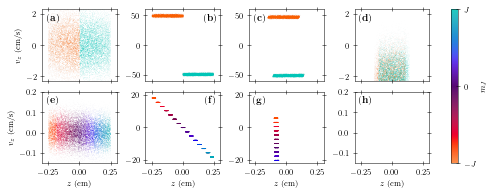

In [17]:
fig, axs = plt.subplots(2,4, figsize=(3.375*2, 2.6), sharex=True, constrained_layout=True)
coordx="z"
coordy="vz"
scale_velocity=False
cmap = "cmr.guppy"
for Ci, C in enumerate([Cs[0], Cs[-1]]):
    for axi, ti in enumerate([1,100, 101,-1][::-1]):
        plot_phasespace_color_mJ(C, axs[Ci, 3-axi], ti=ti, coordx=coordx, coordy=coordy, 
                                scale_velocity=scale_velocity,
                                cmap=cmap,
                                s=0.2)


axs[0,0].set_ylabel("$v_z$ (cm/s)")
axs[1,0].set_ylabel("$v_z$ (cm/s)")
axs[-1,0].set_xlabel("$z$ (cm)")
axs[-1,1].set_xlabel("$z$ (cm)")
axs[-1,2].set_xlabel("$z$ (cm)")
axs[-1,3].set_xlabel("$z$ (cm)")
axs[-1,-1].set_xlim(-0.3, 0.3)
axs[-1,-1].set_xticks([-0.25, 0, 0.25])

axs[0,0].set_ylim(-2.3, 2.3)
axs[0,1].set_ylim(-60, 60)
axs[0,2].set_ylim(-60, 60)
axs[0,-1].set_ylim(-2.3, 2.3)


axs[-1,0].set_ylim(-0.15, 0.2)
axs[-1,1].set_ylim(-22, 22)
axs[-1,2].set_ylim(-22, 22)
axs[-1,-1].set_ylim(-0.15, 0.2)
axs[-1,-1].set_yticks([-0.1, 0.0, 0.1, 0.2])

lettering(axs[0, 0], 0.14, 0.88, 0)
lettering(axs[0, 1], 1-0.14, 0.88, 1)
lettering(axs[0, 2], 0.14, 0.88, 2)
lettering(axs[0, 3], 0.14, 0.88, 3)

lettering(axs[1, 0], 0.14, 0.88, 4)
lettering(axs[1, 1], 1-0.14, 0.88, 5)
lettering(axs[1, 2], 0.14, 0.88, 6)
lettering(axs[1, 3], 0.14, 0.88, 7)



cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(-1,1), cmap=cmap), 
                    ax=axs, location='right', ticks=[-1,0,1])
cbar.ax.set_yticklabels(["$-J$", "$0$", "$J$"]) 
cbar.ax.set_ylabel(r"$m_J$")
#plt.savefig("figures/phase_space_sample.png", dpi=600)
plt.savefig("figures/phase_space_sample.pdf", dpi=600)

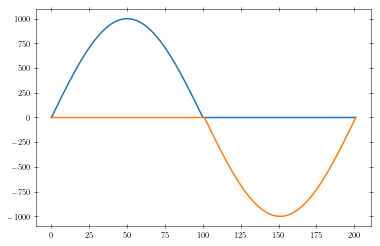

In [18]:
reload(magnetics)
from magnetics import current_pulse
for pulse in C.pulses:
    if pulse["field"] is not None:
        plt.plot(current_pulse(C.ts, **pulse))

In [47]:
1/ratio_opts, t0_opts

(array([[[ 1.94072317],
         [ 6.13249984],
         [10.95032161],
         [13.49667534]],
 
        [[ 1.65790977],
         [ 3.43863226],
         [ 4.08831416],
         [ 4.26032593]]]),
 array([[[ 2112.24489796],
         [ 6142.85714286],
         [19040.81632653],
         [12591.83673469]],
 
        [[ 3724.48979592],
         [ 9367.34693878],
         [26295.91836735],
         [19040.81632653]]]))

Text(0, 0.5, 'Counts')

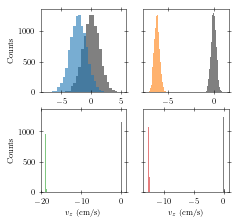

In [20]:
fig, axs = plt.subplots(2,2, figsize=(3.375, 3.375), sharey=True)
for Ci, C in enumerate(Cs):
    r, c = Ci//2, Ci%2
    color = f"C{Ci}"
    axs[r,c].hist(C.states[0, :, 5]*1e6, bins=25, color="grey", alpha=1)
    axs[r,c].hist(C.states[-1, :, 5]*1e6, bins=25, color=color, alpha=0.6)
axs[1,0].set_xlabel("$v_z$ (cm/s)")
axs[1,1].set_xlabel("$v_z$ (cm/s)")
axs[0,0].set_ylabel("Counts")
axs[1,0].set_ylabel("Counts")

Text(0, 0.5, 'Counts')

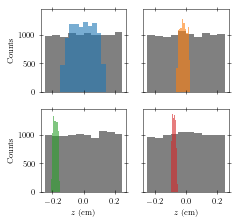

In [21]:
fig, axs = plt.subplots(2,2, figsize=(3.375, 3.375), sharey=True, sharex=True)
for Ci, C in enumerate(Cs):
    r, c = Ci//2, Ci%2
    color = f"C{Ci}"
    axs[r,c].hist(C.states[0, :, 2], bins=10, color="grey", alpha=1)
    axs[r,c].hist(C.states[-1, :,2], bins=10, color=color, alpha=0.6)
axs[1,0].set_xlabel("$z$ (cm)")
axs[1,1].set_xlabel("$z$ (cm)")
axs[0,0].set_ylabel("Counts")
axs[1,0].set_ylabel("Counts")

In [22]:
C.J

8.0

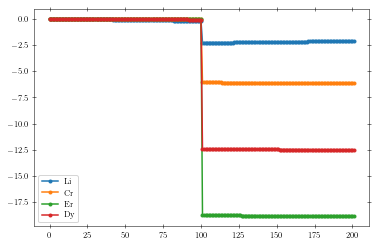

In [23]:
for atom, C in zip(atoms,Cs):
    plt.plot(np.mean(C.states, axis=1)[:,5]*1e6, marker=".", label=atom)
plt.legend()

In [24]:
 C.states.var(axis=1)[0,5], C.states.var(axis=1)[-1,5]

(3.79859140212631e-15, 5.188617457107738e-15)

In [25]:
 C.states.mean(axis=1)[0,5], C.states.mean(axis=1)[-1,5]

(3.835572456209757e-10, -1.2518036717860143e-05)

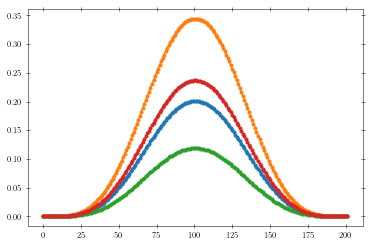

In [26]:
for atom, C in zip(atoms,Cs):
    T = Atoms[atom]["mass"] * C.states.var(axis=1)[:,5] / kB
    plt.plot(T, marker=".")

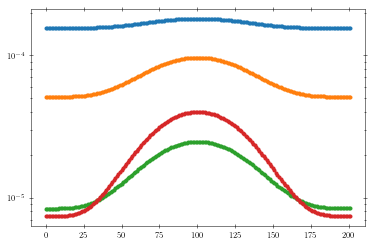

In [27]:
for atom, C in zip(atoms,Cs):
    T = Atoms[atom]["mass"] * C.states.var(axis=1)[:,4] / kB
    plt.semilogy(T, marker=".")